# Visualize target and prior distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


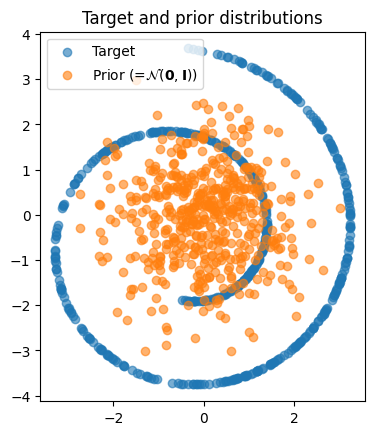

In [9]:
%load_ext autoreload
%autoreload 2

device = "cuda:0"
config = {
    # "num_diffusion_steps": 1000,
    "z_dim": 2,
    "dim_hids": [256, 128], # , 128],
    # "dim_hids": [256, 256, 128],
    "num_iters_in_e_step": 20,
    "lr_m": 1e-4,
    "lr_e": 1.0,
    "batch_size": 128,
    "num_train_iters": 5000,
    # "num_train_iters": 10000,
    "device": device,
}

from dataset import TwoDimDataClass, get_data_iterator
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import io

target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', 'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

# Define a Procedural Memory (Decoder) network

In [10]:
class Decoder(nn.Module):
    def __init__(self, dim_in = config["z_dim"], dim_out = 2, dim_hids = config["dim_hids"]):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_hids = dim_hids
        layers = []
        prev_dim = dim_in
        for dim in dim_hids:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, dim_out))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.layers(z)
    
    def compute_loss(self, z, x):
        return F.mse_loss(self.forward(z), x)

    def compute_loss_e(self, z, x, mu, std):
        # MSE loss and KL divergence to encourage z to be close to N(0, I)
        loss_mse = F.mse_loss(self.forward(z), x)
        # KL divergence for Gaussian distribution
        log_var = 2 * torch.log(std)
        kl_div = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
        loss_kl = kl_div.mean(dim=-1)
        return (loss_mse + 0.1 * loss_kl).mean()    

    def compute_loss_e_v2(self, z, x, mu, sigma):
        # MSE loss and KL divergence to encourage z to be close to N(0, I)
        loss_mse = F.mse_loss(self.forward(z), x)
        # Add small epsilon to prevent log(0)
        eps = 1e-8
        sigma = torch.clamp(sigma, min=eps)
        loss_kl = -0.5 * torch.sum(1 + 2 * torch.log(sigma) - mu**2 - sigma**2, dim=-1)
        return (loss_mse + 0.01 * loss_kl).mean()

    def sample(self, n_examples):
        z_dim = self.dim_in
        z = torch.randn(n_examples, z_dim, device=device)
        return self.forward(z)

decoder = Decoder(dim_in=config["z_dim"], dim_out=2, dim_hids=config["dim_hids"]).to(device)
print(f"model has {sum(p.numel() for p in decoder.parameters())} parameters")

model has 33922 parameters


# Training

loss: 3.236, loss_e: 3.586:   0%|          | 0/5000 [00:00<?, ?it/s]

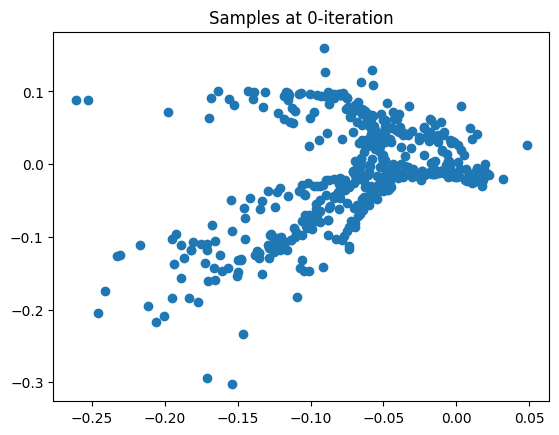

loss: 0.167, loss_e: 0.641: 100%|█████████▉| 4996/5000 [01:59<00:00, 40.87it/s]

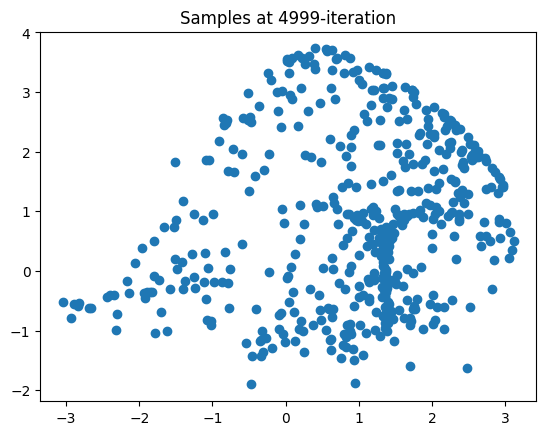

loss: 0.167, loss_e: 0.641: 100%|██████████| 5000/5000 [02:00<00:00, 41.66it/s]


interactive(children=(IntSlider(value=1, description='index', max=1), Output()), _dom_classes=('widget-interac…

Output()

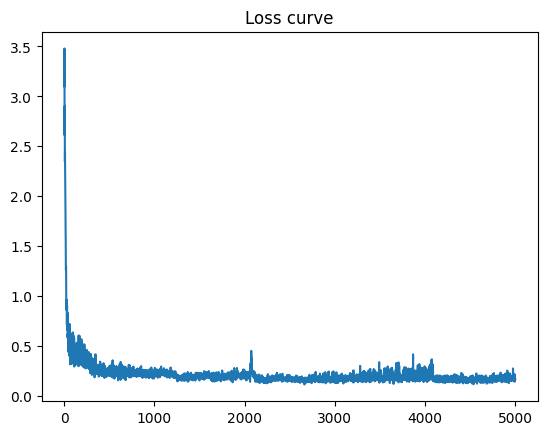

In [11]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Initialize the model.

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(decoder.parameters(), lr=config["lr_m"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()
        
        batch_x = next(train_iter)
        batch_x = batch_x.to(device)

        # create variables mu and sigma with the same shape as batch_z
        # mu and sigma are trainable variables that require gradients
        batch_size = batch_x.shape[0]
        z_dim = config["z_dim"]

        # Initialize mu and log_var with better starting values
        with torch.no_grad():
            mu = torch.zeros(batch_size, z_dim, device=device)
            # log_var = torch.randn(batch_size, z_dim, device=device) * 0.1 - 5.0
            # for debug, fix log_var to be 0
            log_var = torch.zeros_like(mu)
        
        # Enable gradients
        mu.requires_grad_()
        log_var.requires_grad_()
        
        # Create optimizer for E-step
        # e_optimizer = torch.optim.Adam([mu, log_var], lr=config["lr_e"])
        e_optimizer = torch.optim.Adam([mu, log_var], lr=1)
        
        # E step: optimize mu and log_var
        eps = torch.randn_like(mu)  # Generate noise once
        num_iters_in_e_step = config["num_iters_in_e_step"]
        decoder.eval()
        for _ in range(num_iters_in_e_step):
            e_optimizer.zero_grad(set_to_none=True)
            
            # Use log_var instead of sigma directly
            std = torch.exp(0.5 * log_var)
            z = mu + std * eps
            
            loss_e = decoder.compute_loss_e(z=z, x=batch_x, mu=mu, std=std)
            # print(f"loss_e: {loss_e.item():.4f}")
            loss_e.backward()
            e_optimizer.step()
        
        # raise Exception("Stop here")

        # M step: backprop to decoder
        # Detach mu and sigma since we don't want to update them in M step
        with torch.no_grad():
            # the ideal log_var should be 0
            # print(f"mu: {mu.mean().item():.4f}, log_var: {log_var.mean().item():.4f}")
            std = torch.exp(0.5 * log_var)
            z = mu + std * eps
        
        # For debug, make z a deterministic function of x. Normalize z to be close to N(0,1)
        # z = batch_x.mean(dim=1, keepdim=True)
        # z = (z - z.mean()) / z.std()  # Standardize to zero mean and unit variance
        # assert z.shape == (batch_size, z_dim)
        decoder.train()
        optimizer.zero_grad(set_to_none=True)
        loss_m = decoder.compute_loss(z=z, x=batch_x)
        loss_m.backward()
        optimizer.step()

        pbar.set_description(f"loss: {loss_m.item():.3f}, loss_e: {loss_e.item():.3f}")
        
        losses.append(loss_m.item())
        
        if step % 4999 == 0:
            with torch.no_grad():
                x0 = decoder.sample(n_examples=num_vis_particles).cpu()
                ####
                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                # clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)
                
except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

# Evaluation

DDPM Chamfer Distance: 2123.4385


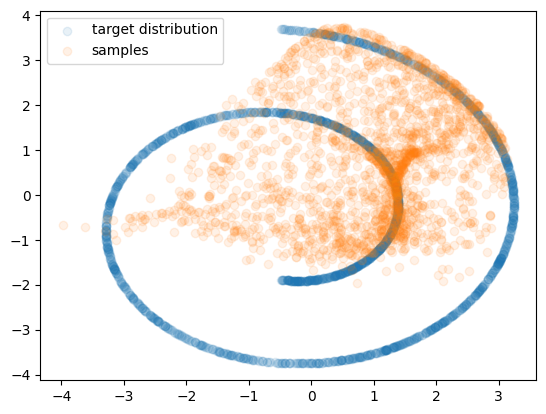

In [12]:
# You will get full credits if your chamfer distance is lower than 20.
from chamferdist import chamfer_distance

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = decoder.sample(n_examples=num_eval_particles)

pc_gen = pc_gen.reshape(1, num_eval_particles, 2)
pc_ref = pc_ref.reshape(1, num_eval_particles, 2)
with torch.no_grad():
    cd = chamfer_distance(
            pc_gen.reshape(-1, 2).cpu().numpy(),
            pc_ref.reshape(-1, 2).cpu().numpy(),
        )
    print(f"DDPM Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
pc_gen = pc_gen.reshape(num_eval_particles, 2).detach().cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).detach().cpu().numpy()

fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()